In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Importing the datasets

In [4]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')   

In [11]:
# --- Define Feature Set ---
# Here, we select a preliminary set of features.
# Adjust the list below based on your final variable names.
feature_cols = ['temperature_C', 'humidity', 'windspeed_kph', 'rain', 'snow', 'thunder',
                 'weekend', 'visibility_km', 'pressure_mBar', 'wind_chill_C', 'wind_direction', 'time_of_day', 'month_str', 'hour', 'month_str', 'wind_chill_bin'] 

X = train_df[feature_cols]
y = train_df['trip_count']

# Optionally, perform any necessary preprocessing such as encoding categorical variables.
# For example, using one-hot encoding for categorical variables:
X = pd.get_dummies(X, columns=['time_of_day', 'month_str', 'wind_direction', 'wind_chill_bin'], drop_first=True)

# Split data into training and local validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model Setup ---
rf = RandomForestRegressor(random_state=42)

# Define the grid search parameters (including max_features interval tuning)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [3, 5, 7, 9]
}

grid_cv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_cv.fit(X_train, y_train)

# Best parameters and cross-validation score
print("Best parameters:", grid_cv.best_params_)
print("Best CV score (MSE):", -grid_cv.best_score_)

# Evaluate on local validation set
best_rf = grid_cv.best_estimator_
y_pred = best_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'max_depth': None, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (MSE): 88.83923015039775
Validation RMSE: 9.278598986353662


In [ ]:
train_df[train_df['trip_count']==0].shape[0] # 0.0

402

In [6]:
train_df['trip_count'].describe()

count    5798.000000
mean       22.699897
std        26.175480
min         0.000000
25%         5.000000
50%        14.000000
75%        30.000000
max       187.000000
Name: trip_count, dtype: float64

<Axes: xlabel='trip_count', ylabel='Count'>

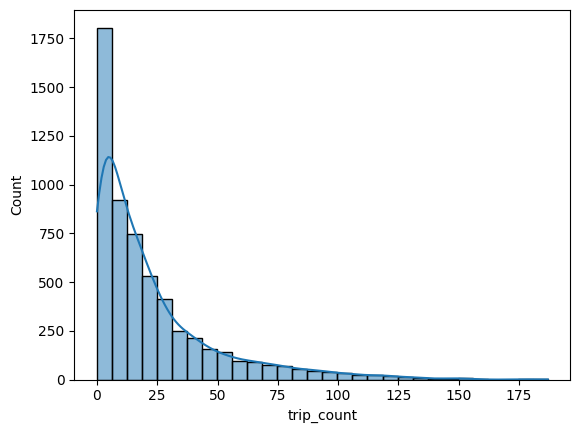

In [7]:
sns.histplot(train_df['trip_count'], bins=30, kde=True)

### Next Steps

#### Fine-tuning and Feature Engineering:
- Experiment with adding interactions or new features (e.g., combining weather with time-of-day or lagged values of trip counts) to see if performance improves.
- Consider including the binned versions of temperature and wind chill if the continuous values don't capture non-linear effects sufficiently.

#### Validation Strategy:
- Given the time-series nature of your data, ensure your validation scheme respects temporal ordering—perhaps using time-based splits (e.g., rolling or expanding windows) rather than random splits.

#### Model Comparison:
- Although Random Forests are strong, you might later compare performance with other models (like XGBoost, Prophet with regressors, or GLMs) to check if further improvements are possible.

#### External Evaluation:
- Once satisfied with your performance on the validation set, proceed with generating predictions for the withheld test set. 
- Remember that withheld labels are intended to assess generalization.


When dealing with time series or any data with temporal trends, random splits can mix up past and future data. This may lead to overly optimistic performance estimates because the model might inadvertently “learn” from future data when predicting past events

In [ ]:
# --- PREPARE DATA ---
# Assume train_df is your training DataFrame already loaded in memory

# Define feature columns – adjust based on your actual DataFrame column names
feature_cols = [
    'temperature_C', 'humidity', 'windspeed_kph', 
    'pressure_mBar', 'visibility_km', 'wind_chill_C', 
    'time_of_day', 'month_str', 'wind_direction',
    'weekend', 'fog', 'rain', 'snow', 'thunder'
]

# Extract features and target
X = train_df[feature_cols]
y = train_df['trip_count']

# Perform one-hot encoding for the categorical variables.
# drop_first=True removes the first category to avoid multicollinearity.
X = pd.get_dummies(X, columns=['time_of_day', 'month_str', 'wind_direction'], drop_first=True)

# --- MODEL SETUP & GRID SEARCH WITH TIMESERIES SPLIT ---
# Instantiate the time series splitter (n_splits defines the number of folds)
tscv = TimeSeriesSplit(n_splits=5)

# Set up the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define grid search parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [3, 5, 7, 9]
}

# Set up grid search with TimeSeriesSplit.
# The cv parameter now uses tscv to ensure our cross-validation maintains the time order.
grid_cv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Run grid search on the entire training set using TimeSeriesSplit for cross-validation.
grid_cv.fit(X, y)

# Display best parameters and best CV score (remember, scoring returns negative MSE so we negate it)
print("Best parameters:", grid_cv.best_params_)
print("Best CV score (MSE):", -grid_cv.best_score_)
